In [1]:
import scipy.stats as stats
import pandas as pd
import numpy as np

# random varaible values and parameter values
df = pd.read_csv('azdiabetes.csv')
X = df[['npreg', 'bp', 'bmi', 'ped', 'age']]
X = (X - X.mean()) / X.std()  # centering and scaling
X['intercept'] = 1
X = X.values
y = df['diabetes'].replace({'Yes': 1, 'No': 0})

/var/folders/dz/lgsl3l_d7fv4z40yrx07rfz80000gn/T/ipykernel_27780/3288299399.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['diabetes'].replace({'Yes': 1, 'No': 0})


In [2]:
from sampler import GibbsSampler

g = len(y)
nu0 = 2
sigma02 = 1

beta_GS, z_GS = GibbsSampler(y, X, g, nu0, sigma02).run_sampler()


In [2]:
from sampler import MetropolisHastingsSampler

mean_beta = np.zeros(6)
cov_beta = np.array([16, 4, 4, 4, 4, 4])
# Likelihood function
def likelihood(x):
    return np.exp(x) / (1 + np.exp(x))

beta_MH, z_MH = MetropolisHastingsSampler(y, X, likelihood, mean_beta, cov_beta).run_sampler()

/Users/cherylshi/UROP/UROP/sampler/sampler.py:168: RuntimeWarning: divide by zero encountered in log
  + np.log(1 - self.likelihood(
/Users/cherylshi/UROP/UROP/sampler/sampler.py:168: RuntimeWarning: invalid value encountered in scalar multiply
  + np.log(1 - self.likelihood(
/Users/cherylshi/UROP/UROP/sampler/sampler.py:173: RuntimeWarning: divide by zero encountered in log
  + np.log(1 - self.likelihood(
/Users/cherylshi/UROP/UROP/sampler/sampler.py:173: RuntimeWarning: invalid value encountered in scalar multiply
  + np.log(1 - self.likelihood(


<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    x        float64 8B 38.11


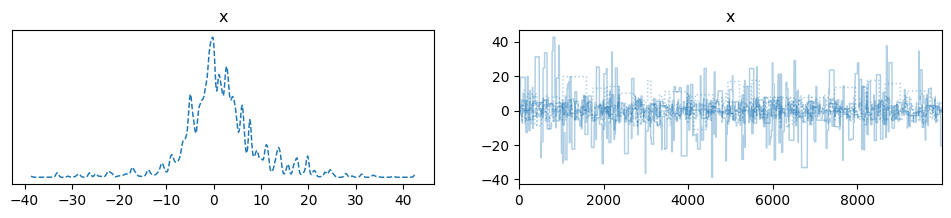

In [3]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

betadata_MH = az.convert_to_dataset(beta_MH.T)

az.plot_trace(betadata_MH, combined=True, compact=True)
print(az.ess(betadata_MH))  # ess should be as large as possible

plt.show()

In [5]:
from sampler import PolyaGamma

beta_PG, z_PG = PolyaGamma(y, X, likelihood, mean_beta, cov_beta).run_sampler()

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    x        float64 8B 7.182


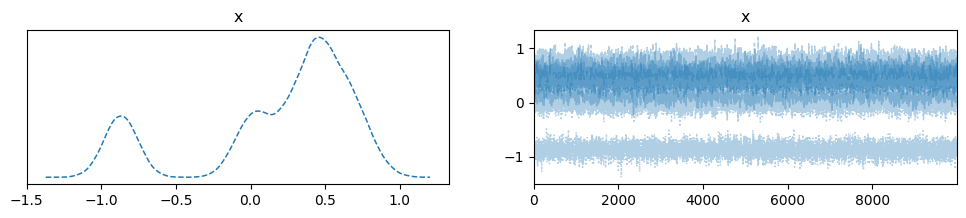

In [10]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

betadata_PG = az.convert_to_dataset(beta_PG.T)

az.plot_trace(betadata_PG, combined=True, compact=True)
print(az.ess(betadata_PG))

plt.show()

In [19]:
beta_GS * z_GS

array([[-0.00674357,  0.        ,  0.00936376, -0.0037442 , -0.00972509,
         0.00737131],
       [ 0.00790243,  0.        , -0.01207477, -0.01408796, -0.00165684,
         0.01894014],
       [-0.01551933,  0.        , -0.00141904,  0.00525909,  0.00862776,
        -0.01327625],
       ...,
       [ 0.00889219,  0.        , -0.01118855,  0.02665227, -0.0157278 ,
         0.00174712],
       [ 0.00876418,  0.        ,  0.00976291,  0.00771981,  0.00705738,
        -0.0019656 ],
       [ 0.02227893,  0.        , -0.00348191,  0.01165224, -0.01045126,
         0.00584959]])

In [30]:
sum(beta_GS[1]*z_GS[1]*X[1])

0.05122105393671954

In [27]:
z_GS[1]

array([1., 0., 1., 1., 1., 1.])

In [26]:
X[1]

array([ 1.05164402, -0.12230772, -1.13211776, -0.98670691,  2.17303872,
        1.        ])

In [5]:
z_MH

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [3]:
np.var(np.log(y+1/2))

0.2679583284550377

In [5]:
y+1/2

0      0.5
1      1.5
2      0.5
3      0.5
4      0.5
      ... 
527    0.5
528    1.5
529    0.5
530    0.5
531    0.5
Name: diabetes, Length: 532, dtype: float64

In [ ]:










                beta_prop = self.beta.copy()
                beta_prop[j] = np.random.uniform(self.beta-delta,
                                                 self.beta+delta)

                p_beta = multivariate_normal.pdf(self.beta, self.mean_beta,
                                                 self.cov_beta)
                J_prop_beta = uniform.pdf(beta_prop,
                                          self.beta-delta, self.beta+delta)
                p_prop_beta = multivariate_normal.pdf(
                    beta_prop, self.mean_beta, self.cov_beta)
                J_beta = uniform.pdf(self.beta,
                                     beta_prop-delta, beta_prop+delta)

                L_prop_beta = sum(np.log(self.likelihood(
                    np.sum(beta_prop * self.z * self.X, axis=1)) ** self.y * (
                        np.ones(len(self.y)) - self.likelihood(
                            np.sum(beta_prop * self.z * self.X, axis=1)))
                            ** (1 - self.y)))

                L_beta = sum(np.log(self.likelihood(
                    np.sum(self.beta * self.z * self.X, axis=1)) ** self.y * (
                        np.ones(len(self.y)) - self.likelihood(
                            np.sum(self.beta * self.z * self.X, axis=1)))
                            ** (1 - self.y)))

                r_log_beta = L_prop_beta + np.log(p_prop_beta) - L_beta
                - np.log(p_beta) + np.log(J_beta) - np.log(J_prop_beta)

                if np.log(uniform()) < min(0, r_log_beta):
                    self.beta = beta_prop

                self.beta_samples[i] = self.beta

            # Sample z
            for r in np.random.permutation(range(1, self.X.shape[1])):
                z_prop = self.z.copy()
                z_prop[r] = 1 - z_prop[r]

                L_prop_z = sum(np.log(self.likelihood(
                    np.sum(self.beta * z_prop * self.X, axis=1)) ** self.y
                    * (np.ones(len(self.y)) - self.likelihood(
                        np.sum(self.beta * z_prop
                               * self.X, axis=1))) ** (1 - self.y)))

                L_z = sum(np.log(self.likelihood(
                    np.sum(self.beta * self.z * self.X, axis=1)) ** self.y
                    * (np.ones(len(self.y)) - self.likelihood(
                        np.sum(self.beta * self.z
                               * self.X, axis=1))) ** (1 - self.y)))

                r_log_gamma = L_prop_z - L_z

                if np.log(uniform()) < min(0, r_log_gamma):
                    self.z = z_prop

            self.z_samples[i] = self.z


In [12]:
from scipy.stats import uniform
delta = 1/32
b = np.random.uniform(beta_GS[0,0]-delta, beta_GS[0,0]+delta)
uniform.pdf(b, loc=beta_GS[0,0] - delta, scale=2*delta)

16.0

In [7]:
help(uniform.pdf)

Help on method pdf in module scipy.stats._distn_infrastructure:

pdf(x, *args, **kwds) method of scipy.stats._continuous_distns.uniform_gen instance
    Probability density function at x of the given RV.
    
    Parameters
    ----------
    x : array_like
        quantiles
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    pdf : ndarray
        Probability density function evaluated at x



In [13]:
beta_GS[0,0]-delta

-0.033252764463733965

In [14]:
beta_GS[0,0]+delta

0.02924723553626603

In [16]:
(b-(beta_GS[0,0]-delta))/(2*delta)

0.19251098267012845